<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

The objective in this exercise is to build the functions that you will need to create your histogram filter. The histogram filter represents the state as a fixed set of hypotheses that correspond to the centroids of evenly spaced cells. Each one of these hypothesis has an associated weight, and the weights should sum to one. As a result, the histogram corresponds to a valid belief distribution over the state space. In math we can write this as a weighted sum of Dirac delta functions:

$bel(x_t) =  \sum_{i=1}^N w^i_t \delta(x_t - x^i)$

The API for this (and really any) filter will comprise three functions: `prior()`, `predict()` and `update()`. The `prior()` function sets up the initial belief weights, $w_0$ over the histogram. 

The `predict()` function propagates forward the belief weights based on the motion model and the control, $u_t$. This amounts to propagating the centroids of each of the cells forward and then adding all of the weight up that lands in each bin. 

$\overline{bel}(x_t) =  \sum_{i=1}^N \sum_{j=1}^N w_{t-1}^j p(x^i|x^j,u_t) \delta(x_t - x^i)$

In our case we will be using the odometry as a proxy for the control input so that we may use a simple kinematic model of the robot. 

Finally, the `update()` function takes a measurement and uses it to update the weights of the histogram bins based on the incoming measurement, $z_t$. This is achieved by multiplying the weight in each bin by the likelihood that the measurement was generated by the state corresponding to the centroid of that bin:

$bel(x_t) = \sum_{i=1}^N \frac{\overline{w}^i_t p(z_t|x^i)}{\displaystyle\sum_{j=1}^N \overline{w}^j_t p(z_t|x^j)}\delta(x_t - x^i)$

In this notebook we will proceed by loading one image and using the line detection and ground projection algorithms (we can consider them as a black box here) to detect all of the white and yellow line segments. Each line segment will contribute a vote in the measurement likelihood. 

After running `dts exercises build` these functions can be used on the simulated or real Duckiebot using `dts exercises test`. This will use the real (or simulated) data coming from your camera instead of the single image that we loaded here. 


In [1]:
# start by importing some things we will need
import cv2
import matplotlib
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import entropy, multivariate_normal
from math import floor, sqrt

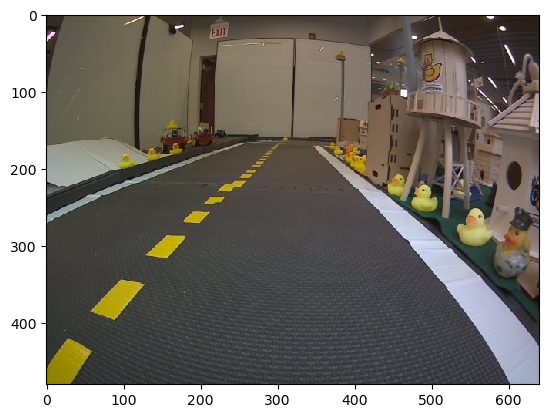

In [2]:
# Now let's load the image that we will use. Feel free to change it, 
# but the calibrations in the setup/calibrations folder should correspond to the robot
# that took the image
from matplotlib.pyplot import imshow
%matplotlib inline
img = cv2.imread("../../assets/images/pic1.png")
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

We will define the state here to be the comprised of the distance from the center of the lane $d$ and the angle relative to the lane $\phi$. 

![](../../assets/images/state.png)

In [3]:
# Now we will load parameters from the configuration file
# These are the same parameters that will be loaded when we do 
# dts exercises test. Feel free to experiment with different values
# for any of the parameters
import yaml
with open("../../packages/lane_filter/config/lane_filter_node/default.yaml", "r") as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
hp = params["lane_filter_histogram_configuration"]
print(hp)

d, phi = np.mgrid[hp['d_min'] : hp['d_max'] : hp['delta_d'], hp['phi_min'] : hp['phi_max'] : hp['delta_phi']]

# We are going to organize them into some data structures so that they are easier to move around
grid_spec = {
    "d": d,
    "phi": phi,
    "delta_d": hp['delta_d'],
    "delta_phi": hp['delta_phi'],
    "d_min": hp['d_min'],
    "d_max": hp['d_max'],
    "phi_min": hp['phi_min'],
    "phi_max": hp['phi_max'],
}
road_spec = {
    "linewidth_white": hp['linewidth_white'],
    "linewidth_yellow": hp['linewidth_yellow'],
    "lanewidth": hp['lanewidth'],
}
robot_spec = {
    "wheel_radius": hp['wheel_radius'],
    "wheel_baseline": hp['wheel_baseline'],
    "encoder_resolution": hp['encoder_resolution'],
}

# The "cov_mask" is effectively the process model covariance
cov_mask = [hp['sigma_d_mask'], hp['sigma_phi_mask']]
belief = np.empty(d.shape)
mean_0 = [hp['mean_d_0'], hp['mean_phi_0']]
cov_0 = [[hp['sigma_d_0'], 0], [0, hp['sigma_phi_0']]]


FileNotFoundError: [Errno 2] No such file or directory: '../../packages/lane_filter/config/lane_filter_node/default.yaml'

In [ ]:
# Now let's define the prior function. In this case we choose
# to initialize the historgram based on a Gaussian distribution around [0,0]
def histogram_prior(belief, grid_spec, mean_0, cov_0):
    pos = np.empty(belief.shape + (2,))
    pos[:, :, 0] = grid_spec["d"]
    pos[:, :, 1] = grid_spec["phi"]
    RV = multivariate_normal(mean_0, cov_0)
    belief = RV.pdf(pos)
    return belief

In [ ]:
# Now let's define the predict function


def histogram_predict(belief, left_encoder_ticks, right_encoder_ticks, grid_spec, robot_spec, cov_mask):
        belief_in = belief

        
        # TODO propagate each centroid forward using the kinematic function
        d_t = grid_spec['d'] # replace this with something that adds the new odometry
        phi_t = grid_spec['phi'] # replace this with something that adds the new odometry

        p_belief = np.zeros(belief.shape)

        # Accumulate the mass for each cell as a result of the propagation step
        for i in range(belief.shape[0]):
            for j in range(belief.shape[1]):
                # If belief[i,j] there was no mass to move in the first place
                if belief[i, j] > 0:
                    # Now check that the centroid of the cell wasn't propagated out of the allowable range
                    if (
                        d_t[i, j] > grid_spec['d_max']
                        or d_t[i, j] < grid_spec['d_min']
                        or phi_t[i, j] < grid_spec['phi_min']
                        or phi_t[i, j] > grid_spec['phi_max']
                    ):
                        continue
                    
                    # TODO Now find the cell where the new mass should be added
                    i_new = i # replace with something that accounts for the movement of the robot
                    j_new = j # replace with something that accounts for the movement of the robot

                    p_belief[i_new, j_new] += belief[i, j]

        # Finally we are going to add some "noise" according to the process model noise
        # This is implemented as a Gaussian blur over the histogram
        s_belief = np.zeros(belief.shape)
        gaussian_filter(p_belief, cov_mask, output=s_belief, mode="constant")

        if np.sum(s_belief) == 0:
            return belief_in
        belief = s_belief / np.sum(s_belief)
        return belief


Now we are going to work on building the measurement likelihood. We will have as an input a list of segments. Each segment has endpoints, a normal vector, and an associated color. For each segment, we will use basic geometry to figure out what position ($d$) and orientation ($\phi$) the robot would have had to have been at to detect the specific segment assuming that it did in fact come from a road marking. 

There is a bit of annoying detail here since we can detect lines on either side of the actual lane markings. We use the normals to determine which side of the lane marking the line was on. The following shows the `lanewidth` and the `linewidth_yellow` and `linewidth_white` parameters.

The following image shows a representations of how the detected line segments sit on an actual lane

<p style="text-align: center">
  <img src="../../assets/images/03-histogram-filter/detected_line_segments.png" alt="detected line segments" width="200">
</p>
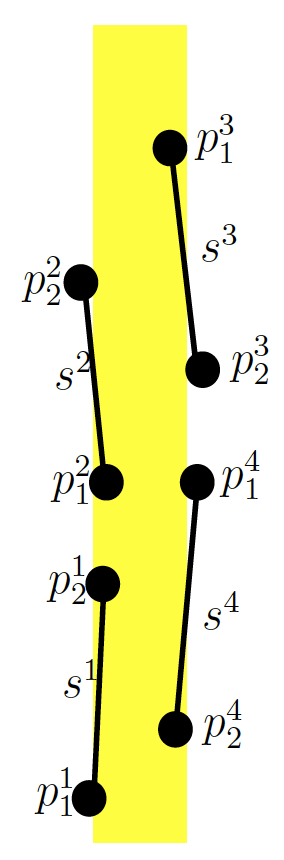

In [ ]:
# We will start by doing a little bit of processing on the segments to remove anything that is behing the robot (why would it be behind?)
# or a color not equal to yellow or white

def prepare_segments(segments):
    filtered_segments = []
    for segment in segments:

        # we don't care about RED ones for now
        if segment.color != segment.WHITE and segment.color != segment.YELLOW:
            continue
        # filter out any segments that are behind us
        if segment.points[0].x < 0 or segment.points[1].x < 0:
            continue

        filtered_segments.append(segment)
    return filtered_segments

Now for each segment we will generate a vote according to:

<p style="text-align: center">
  <img src="../../assets/images/03-histogram-filter/Votingalgorithm.png" alt="detected line segments" width="1000">
</p>
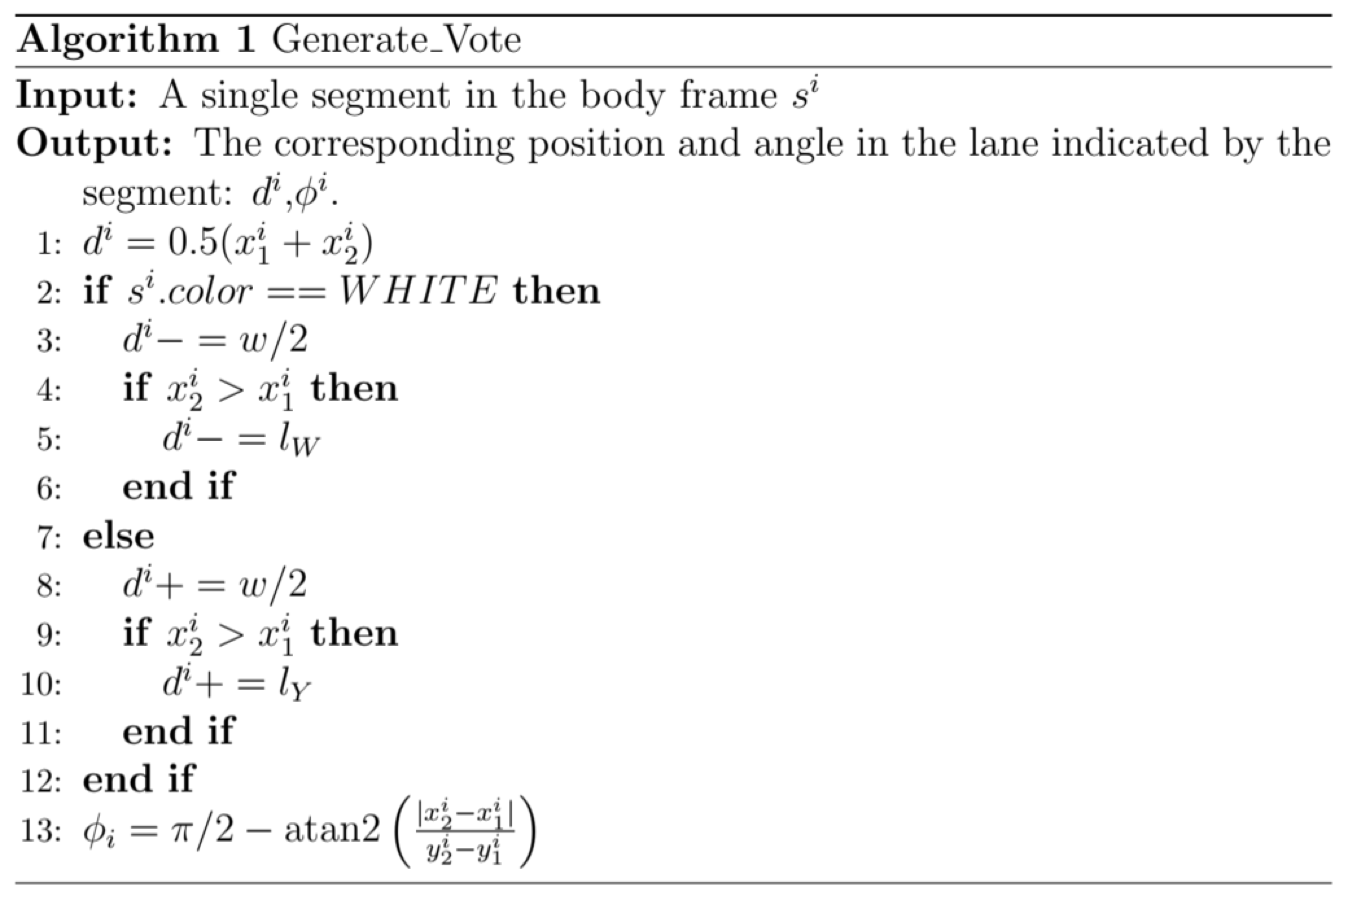

In [ ]:

def generate_vote(segment, road_spec):
    p1 = np.array([segment.points[0].x, segment.points[0].y])
    p2 = np.array([segment.points[1].x, segment.points[1].y])
    t_hat = (p2 - p1) / np.linalg.norm(p2 - p1)
    n_hat = np.array([-t_hat[1], t_hat[0]])
    
    d1 = np.inner(n_hat, p1)
    d2 = np.inner(n_hat, p2)
    l1 = np.inner(t_hat, p1)
    l2 = np.inner(t_hat, p2)
    if l1 < 0:
        l1 = -l1
    if l2 < 0:
        l2 = -l2

    l_i = (l1 + l2) / 2
    d_i = (d1 + d2) / 2
    phi_i = np.arcsin(t_hat[1])
    if segment.color == segment.WHITE:  # right lane is white
        if p1[0] > p2[0]:  # right edge of white lane
            d_i -= road_spec['linewidth_white']
        else:  # left edge of white lane
            d_i = -d_i
            phi_i = -phi_i
        d_i -= road_spec['lanewidth'] / 2

    elif segment.color == segment.YELLOW:  # left lane is yellow
        if p2[0] > p1[0]:  # left edge of yellow lane
            d_i -= road_spec['linewidth_yellow']
            phi_i = -phi_i
        else:  # right edge of white lane
            d_i = -d_i
        d_i = road_spec['lanewidth'] / 2 - d_i

    return d_i, phi_i

Now we generate the entire measurement likelihood by generating a vote for each line segment in the list that we received. The measurement likelihood will itself be a histogram:

<p style="text-align: center">
  <img src="../../assets/images/03-histogram-filter/Histogram.png" alt="detected line segments" width="600">
</p>
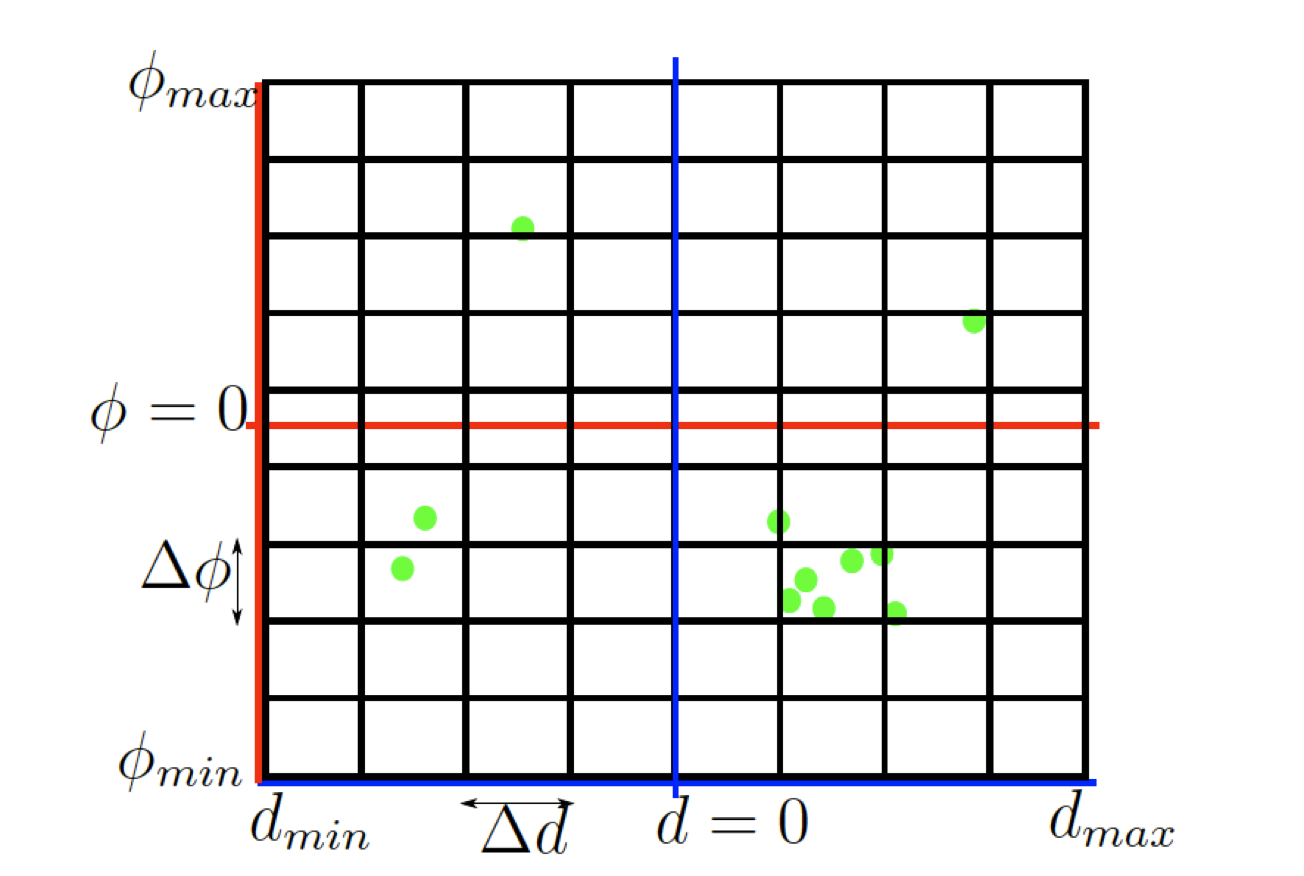

In [ ]:
def generate_measurement_likelihood(segments, road_spec, grid_spec):

    # initialize measurement likelihood to all zeros
    measurement_likelihood = np.zeros(grid_spec['d'].shape)

    for segment in segments:
        d_i, phi_i = generate_vote(segment, road_spec)

        # if the vote lands outside of the histogram discard it
        if d_i > grid_spec['d_max'] or d_i < grid_spec['d_min'] or phi_i < grid_spec['phi_min'] or phi_i > grid_spec['phi_max']:
            continue

        # TODO find the cell index that corresponds to the measurement d_i, phi_i
        i = 1 # replace this
        j = 1 # replace this
        
        # Add one vote to that cell
        measurement_likelihood[i, j] += 1

    if np.linalg.norm(measurement_likelihood) == 0:
        return None
    measurement_likelihood /= np.sum(measurement_likelihood)
    return measurement_likelihood


Now we have everything we need for the update function. 

In [ ]:
def histogram_update(belief, segments, road_spec, grid_spec):
    # prepare the segments for each belief array
    segmentsArray = prepare_segments(segments)
    # generate all belief arrays

    measurement_likelihood = generate_measurement_likelihood(segmentsArray, road_spec, grid_spec)

    if measurement_likelihood is not None:
        # TODO: combine the prior belief and the measurement likelihood to get the posterior belief
        # Don't forget that you may need to normalize to ensure that the output is valid probability distribution
        belief = measurement_likelihood # replace this with something that combines the belief and the measurement_likelihood
    return (measurement_likelihood, belief)


Now we have defined the `prior()`, `predict()` and `update()` functions. We will test one cycle of the filter here to see if things look reasonable. 

In [ ]:
# Let's start initializing the belief:
belief = histogram_prior(belief, grid_spec, mean_0, cov_0)
imshow(belief)


In [ ]:
# Now let's generate some fake encoder data and do one step of the prediction function:

left = 10 # left ticks
right = 20 # right ticks
belief = histogram_predict(belief, left, right, grid_spec, robot_spec, cov_mask)
imshow(belief)

In [ ]:
# This cell will take the image that we loaded and detect the line segments and project them onto the ground plane. 
# We don't need to worry too much about details here.

from complete_image_pipeline.pipeline import run_pipeline
from typing import Dict, Tuple


import duckietown_code_utils as dtu
from anti_instagram import AntiInstagramInterface
from duckietown_msgs.msg import Segment, SegmentList
from duckietown_segmaps import FRAME_AXLE, FRAME_GLOBAL
from duckietown_segmaps.draw_map_on_images import plot_map, predict_segments
from duckietown_segmaps.maps import plot_map_and_segments
from duckietown_segmaps.transformations import TransformationsInfo
from easy_algo import get_easy_algo_db
from easy_node.utils.timing import FakeContext, ProcessingTimingStats
from ground_projection.ground_projection_interface import find_ground_coordinates
from ground_projection.segment import rectify_segments
from image_processing.ground_projection_geometry import GroundProjectionGeometry
from image_processing.rectification import Rectify
from line_detector2.image_prep import ImagePrep
from line_detector_interface import FAMILY_LINE_DETECTOR
from line_detector_interface.visual_state_fancy_display import normalized_to_image, vs_fancy_display
from localization_templates import FAMILY_LOC_TEMPLATES
import duckietown_code_utils as dtu
from image_processing.more_utils import get_robot_camera_geometry
import matplotlib.pyplot as plt
line_detector_name="baseline"
image_prep_name="baseline"
anti_instagram_name="baseline"
robot_name = "lab"
rcg = get_robot_camera_geometry(robot_name)

dtu.check_isinstance(img, np.ndarray)

algo_db = get_easy_algo_db()
line_detector = algo_db.create_instance(FAMILY_LINE_DETECTOR, line_detector_name)
image_prep = algo_db.create_instance(ImagePrep.FAMILY, image_prep_name)
ai = algo_db.create_instance(AntiInstagramInterface.FAMILY, anti_instagram_name)
segment_list = image_prep.process(FakeContext(), img, line_detector, transform=None)
jpg1 = vs_fancy_display(image_prep.image_cv, segment_list)

jpg1 = jpg1.copy()
jpg1[np.all(jpg1 == (255,255,255), axis=-1)] = (0,0,0)
imshow(cv2.cvtColor(np.float32(jpg1), cv2.COLOR_BGR2RGB))

segment_list_rect = rectify_segments(rcg.rectifier, rcg.gpg , segment_list)

sg = find_ground_coordinates(rcg.gpg, segment_list_rect)

In [ ]:
# Finally we can take the ground projected segments and call our update function
(measurement_likelihood, belief) = histogram_update(belief,sg.segments, road_spec, grid_spec)
imshow(belief)